In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [16]:
gray_dir = '/kaggle/input/landscape-image-colorization/landscape Images/gray'
color_dir = '/kaggle/input/landscape-image-colorization/landscape Images/color'

In [17]:
def load_image_pairs(gray_dir, color_dir, max_samples=None):
    gray_paths = []
    color_paths = []
    
    for fname in os.listdir(gray_dir):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            gray_path = os.path.join(gray_dir, fname)
            color_path = os.path.join(color_dir, fname)
            if os.path.exists(color_path):
                gray_paths.append(gray_path)
                color_paths.append(color_path)
    
    if max_samples:
        gray_paths = gray_paths[:max_samples]
        color_paths = color_paths[:max_samples]
    
    gray_images = []
    color_images = []
    
    for gray_path, color_path in zip(gray_paths, color_paths):
        try:
            gray_img = image.load_img(gray_path, target_size=IMAGE_SIZE, color_mode='grayscale')
            gray_array = image.img_to_array(gray_img) / 255.0
            
            color_img = image.load_img(color_path, target_size=IMAGE_SIZE, color_mode='rgb')
            color_array = image.img_to_array(color_img) / 255.0
            
            gray_images.append(gray_array)
            color_images.append(color_array)
        except Exception as e:
            print(f"Skipping pair {gray_path}, {color_path}: {e}")
    
    return np.array(gray_images), np.array(color_images)

In [18]:
X, y = load_image_pairs(gray_dir, color_dir, max_samples=2000)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [19]:
IMAGE_SIZE = (128, 128)  
BATCH_SIZE = 32
EPOCHS = 30
LATENT_DIM = 128

In [20]:

def build_colorization_model(input_shape=(128, 128, 1)):

    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Decoder
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Output
    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    model = models.Model(inputs, outputs)
    return model



In [21]:
model = build_colorization_model()
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='mean_squared_error',
              metrics=['mae'])

In [22]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True) 
]

In [23]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - loss: 0.0555 - mae: 0.1727 - val_loss: 0.0700 - val_mae: 0.2264
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0210 - mae: 0.1075 - val_loss: 0.0670 - val_mae: 0.2204
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0196 - mae: 0.1041 - val_loss: 0.0635 - val_mae: 0.2140
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0181 - mae: 0.0993 - val_loss: 0.0593 - val_mae: 0.2053
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0173 - mae: 0.0966 - val_loss: 0.0525 - val_mae: 0.1920
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0167 - mae: 0.0945 - val_loss: 0.0454 - val_mae: 0.1776
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0161 - mae: 0.0924 - val_loss: 0.0364 - val_mae: 0.1578
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0154 - mae: 0.0905 - val_loss: 0.0321 - val_mae: 0.1471
Epoch 9/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


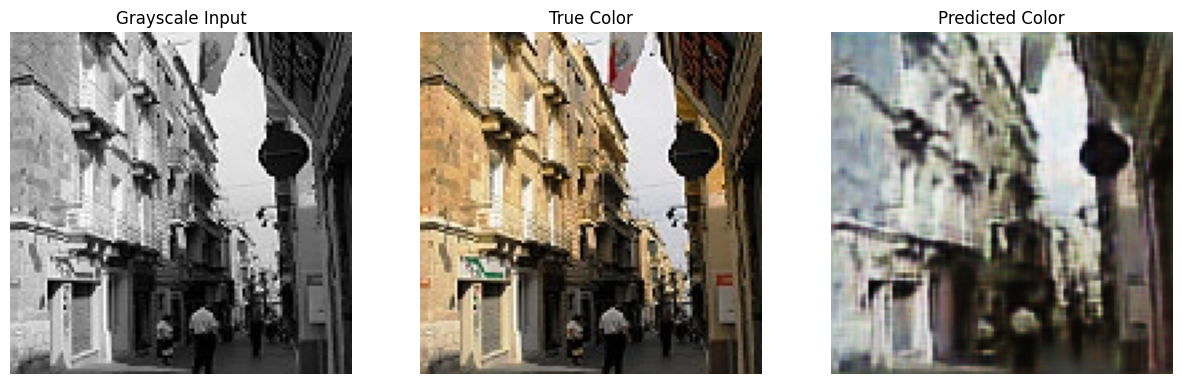

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


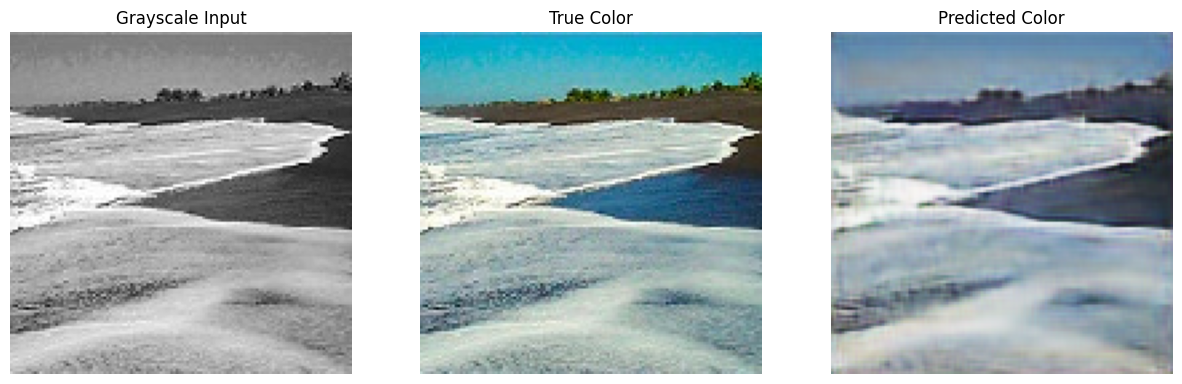

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


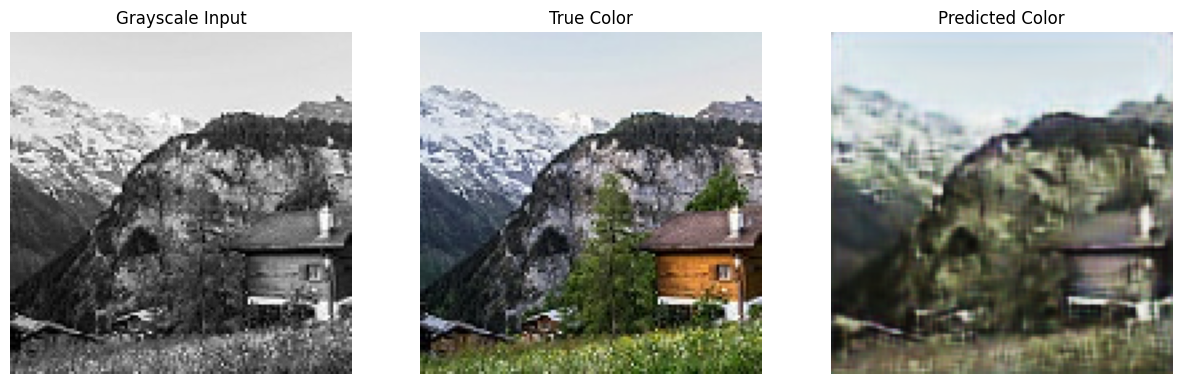

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


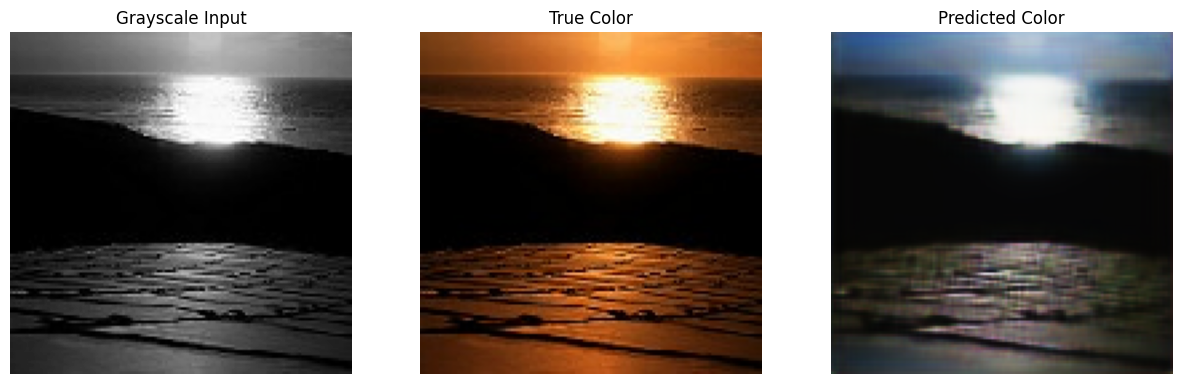

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


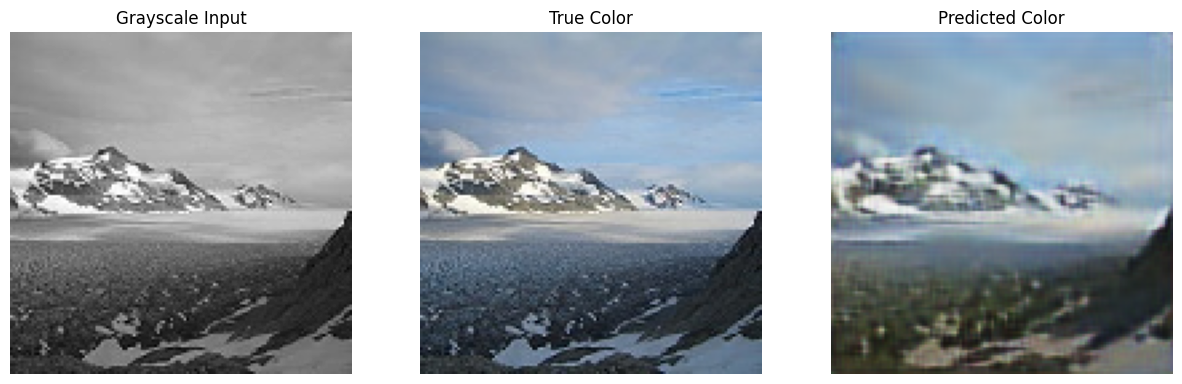

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


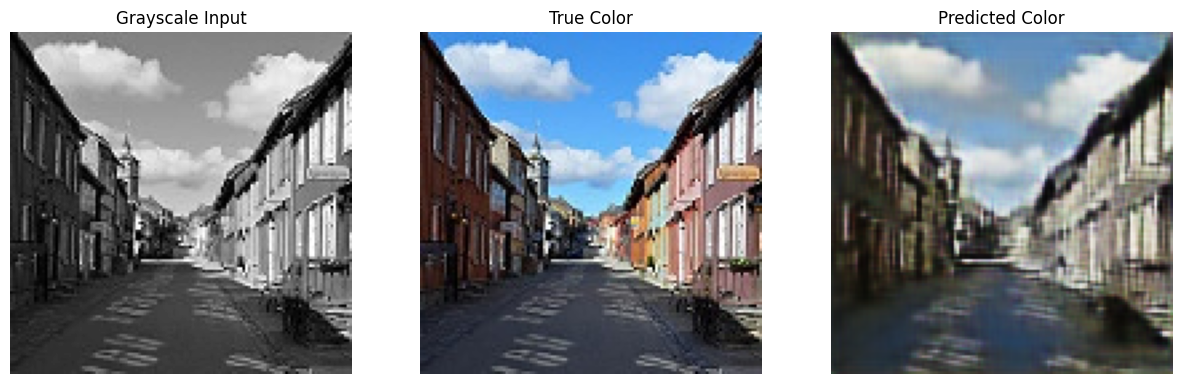

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


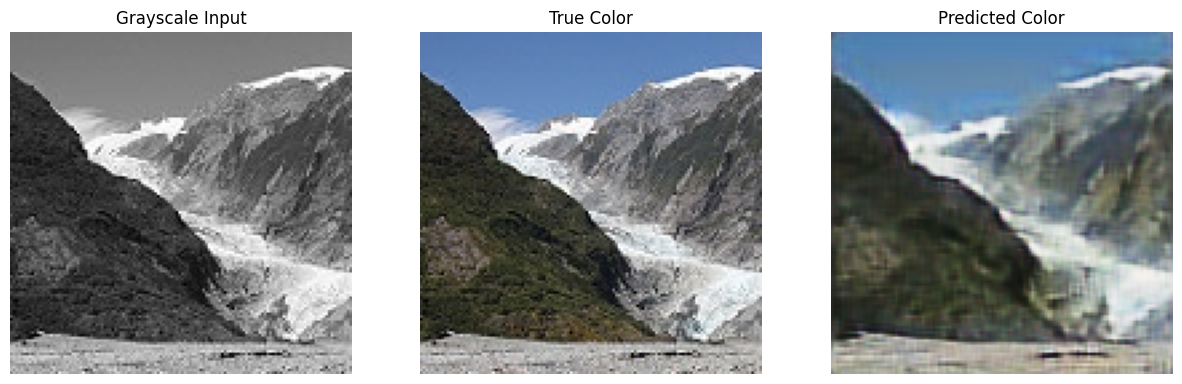

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


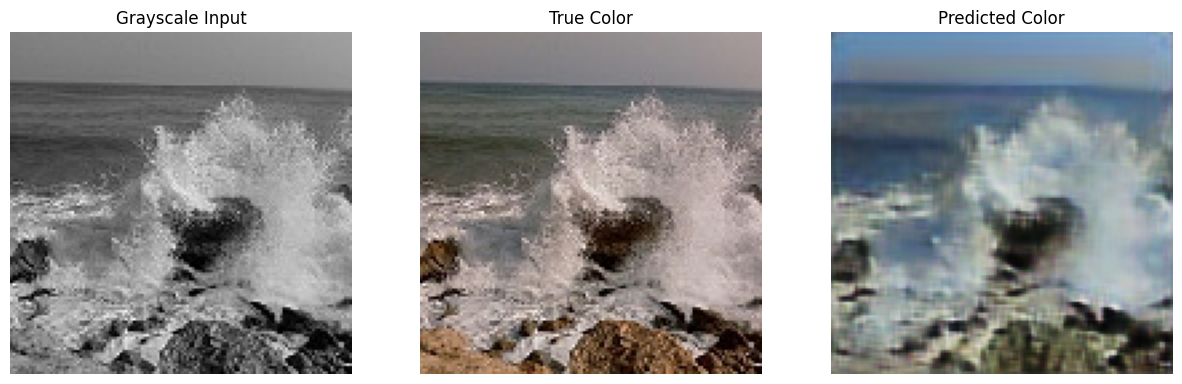

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


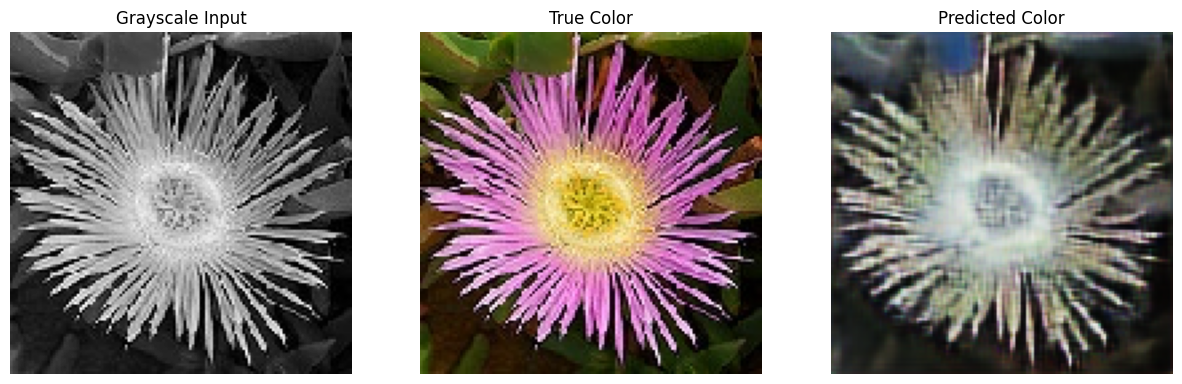

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


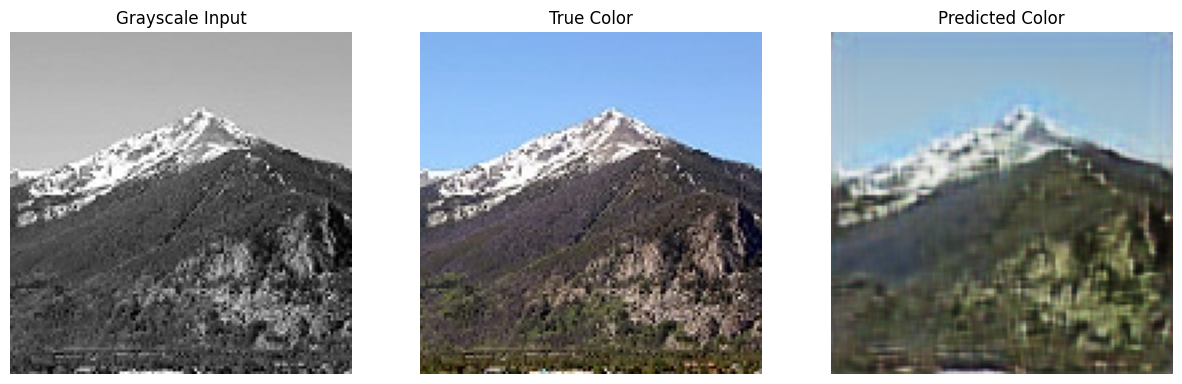

In [24]:
def display_results(images, titles, cmap=None):
    plt.figure(figsize=(15, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i], cmap=cmap[i] if cmap else None)
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

sample_idx = np.random.choice(len(X_test), 10, replace=False)

for idx in sample_idx:
    gray = X_test[idx]
    true_color = y_test[idx]
    pred_color = model.predict(gray[np.newaxis, ...])[0]
    
    display_results(
        [gray.squeeze(), true_color, pred_color],
        ['Grayscale Input', 'True Color', 'Predicted Color'],
        cmap=['gray', None, None]
    )